In [1]:
"""
crop_muzzles_no_main.py
Detects cattle muzzles with a YOLO-v8 model, crops the best bbox in every
image under IN_ROOT, and saves the crops under OUT_ROOT while preserving the
original folder structure.

DEPENDENCIES
------------
pip install ultralytics opencv-python tqdm
"""

# ──────────────────────────────────────────────────────────────────────────────
# Imports
# ──────────────────────────────────────────────────────────────────────────────
from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# ──────────────────────────────────────────────────────────────────────────────
# Helper functions
# ──────────────────────────────────────────────────────────────────────────────
def best_box(boxes):
    """
    Return (x1, y1, x2, y2, conf) for the highest-confidence detection
    or None if no detections.
    """
    if boxes is None or len(boxes) == 0:
        return None
    idx  = boxes.conf.argmax()
    xyxy = boxes.xyxy[idx].cpu().numpy()   # (4,)
    conf = float(boxes.conf[idx])
    return (*xyxy, conf)


def crop_with_padding(img, xyxy, pad=0):
    """
    Crop an ROI with optional pixel padding (pad can be 0).
    xyxy must be absolute coordinates (x1, y1, x2, y2).
    """
    h, w = img.shape[:2]
    x1, y1, x2, y2 = map(int, xyxy)

    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad)
    y2 = min(h, y2 + pad)

    return img[y1:y2, x1:x2]


# ──────────────────────────────────────────────────────────────────────────────
# USER CONFIG  ← EDIT THESE PATHS / VALUES
# ──────────────────────────────────────────────────────────────────────────────
IN_ROOT    = Path("filtered_cattle_dataset")  # folder with cattle_1/, cattle_2/, ...
OUT_ROOT   = Path("cropped_muzzles")          # crops will be saved here
MODEL_PATH = "model.pt"                            # your YOLO-v8 weights
PADDING    = 10     # pixels around bbox (0 for none)
CONF_THRES = 0.25   # discard detections below this confidence
IMG_SIZE   = 640    # inference resolution (adjust if desired)

# ──────────────────────────────────────────────────────────────────────────────
# Preparations
# ──────────────────────────────────────────────────────────────────────────────
OUT_ROOT.mkdir(parents=True, exist_ok=True)

model = YOLO(MODEL_PATH)

# Collect image files
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_paths = [p for p in IN_ROOT.rglob("*") if p.suffix.lower() in valid_exts]

print(f"Found {len(image_paths)} images under {IN_ROOT}")

# ──────────────────────────────────────────────────────────────────────────────
# Main processing loop
# ──────────────────────────────────────────────────────────────────────────────
for img_path in tqdm(image_paths, desc="Cropping muzzles"):
    # 1) Run detector
    result = model.predict(
        source=str(img_path),
        conf=CONF_THRES,
        imgsz=IMG_SIZE,
        max_det=5,        # change if you need more than 5 boxes returned
        verbose=False,
    )[0]

    # 2) Choose the best bbox (or loop over result.boxes to save all)
    bb = best_box(result.boxes)
    if bb is None:
        continue  # skip if no muzzle found

    x1, y1, x2, y2, conf = bb

    # 3) Load image & crop
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[WARN] Could not read {img_path}")
        continue

    crop = crop_with_padding(img, (x1, y1, x2, y2), pad=PADDING)
    if crop.size == 0:
        print(f"[WARN] Empty crop for {img_path}")
        continue

    # 4) Build output path, mirroring folder structure
    rel_path = img_path.relative_to(IN_ROOT)   # e.g. cattle_8/IMG_123.jpg
    out_path = OUT_ROOT / rel_path
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # 5) Save crop
    cv2.imwrite(str(out_path), crop)

print(f"✅  Done! Cropped images saved under {OUT_ROOT}")

Found 117 images under filtered_cattle_dataset


Cropping muzzles: 100%|██████████| 117/117 [00:13<00:00,  8.90it/s]

✅  Done! Cropped images saved under cropped_muzzles


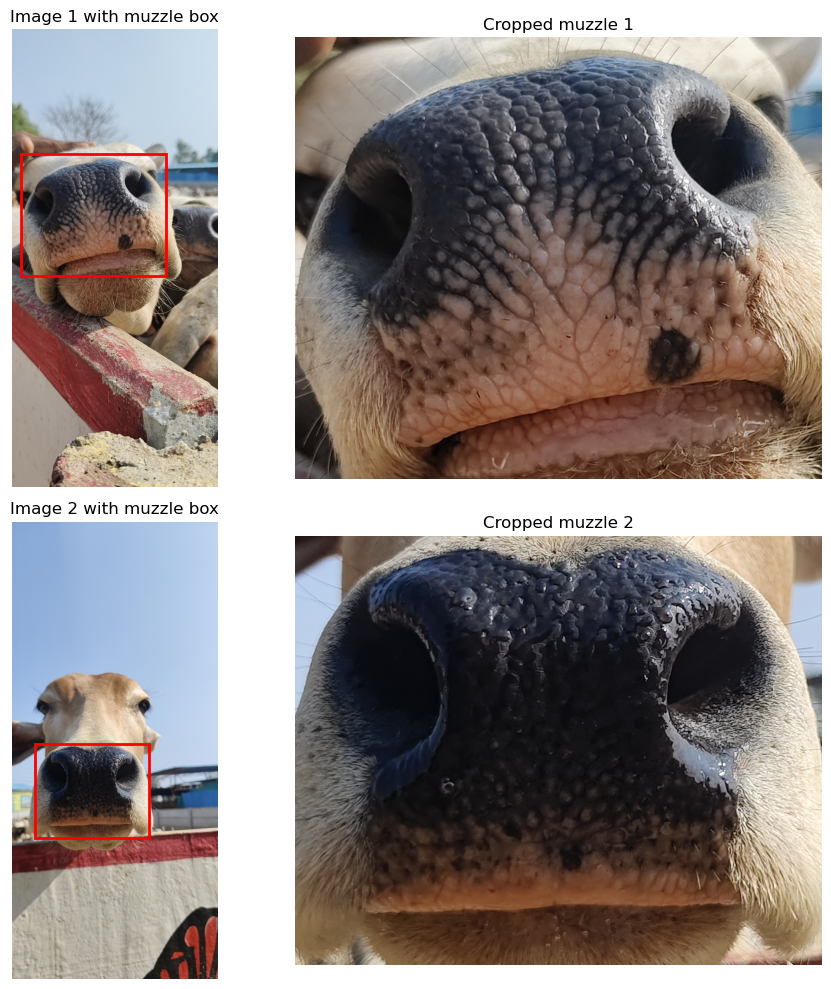

In [2]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ─────────────────────── USER SETTINGS ────────────────────────
img1_path   = '/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_3/IMG_20241108_092618.jpg'
img2_path   = '/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_5/IMG_20241108_093433.jpg'
model_path  = 'model.pt'   # YOLO weights
PADDING     = 10           # pixels around bbox
CONF_THRES  = 0.35         # confidence threshold
# ───────────────────────────────────────────────────────────────

detector = YOLO(model_path)

def crop_first_muzzle(img_path, pad=PADDING, conf=CONF_THRES):
    """Return (original_RGB, crop_RGB, bbox tuple) for the best muzzle."""
    bgr  = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(img_path)
    rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    res  = detector.predict(rgb, conf=conf, verbose=False)[0]
    if len(res.boxes) == 0:
        raise ValueError(f'No muzzle found in {img_path}')

    # highest-confidence box
    idx           = res.boxes.conf.argmax()
    x1, y1, x2, y2 = res.boxes.xyxy[idx].cpu().numpy().astype(int)

    # padding
    h, w = rgb.shape[:2]
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad); y2 = min(h, y2 + pad)

    crop = rgb[y1:y2, x1:x2]
    return rgb, crop, (x1, y1, x2, y2)

# --- Process the two images --------------------------------------------------
orig1, crop1, box1 = crop_first_muzzle(img1_path)
orig2, crop2, box2 = crop_first_muzzle(img2_path)

# --- Plot --------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Original 1 with bbox
axes[0, 0].imshow(orig1)
axes[0, 0].add_patch(plt.Rectangle((box1[0], box1[1]),
                                   box1[2]-box1[0], box1[3]-box1[1],
                                   fill=False, color='red', linewidth=2))
axes[0, 0].set_title('Image 1 with muzzle box'); axes[0, 0].axis('off')

# Crop 1
axes[0, 1].imshow(crop1); axes[0, 1].set_title('Cropped muzzle 1'); axes[0, 1].axis('off')

# Original 2 with bbox
axes[1, 0].imshow(orig2)
axes[1, 0].add_patch(plt.Rectangle((box2[0], box2[1]),
                                   box2[2]-box2[0], box2[3]-box2[1],
                                   fill=False, color='red', linewidth=2))
axes[1, 0].set_title('Image 2 with muzzle box'); axes[1, 0].axis('off')

# Crop 2
axes[1, 1].imshow(crop2); axes[1, 1].set_title('Cropped muzzle 2'); axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# ─────────────────────────── imports ───────────────────────────
import cv2, torch, torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ─────────────────────── USER SETTINGS ────────────────────────
img1_path   = '/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_21/IMG_20241108_103926.jpg'
img2_path   = '/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_3/IMG_20241108_092621.jpg'
yolo_weights = 'model.pt'                # muzzle detector
feat_weights = 'feature_extractor.pth'   # ResNet-50 feature extractor
PADDING      = 10                        # pixels around bbox (0 → tight)
CONF_THRES   = 0.35                      # YOLO confidence threshold
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
# ───────────────────────────────────────────────────────────────

# ── 1. Load YOLO muzzle detector
detector = YOLO(yolo_weights)

# ── 2. Build & load feature extractor (same architecture used in training)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        net = torchvision.models.resnet50(weights=None)       # no ImageNet weights
        self.features = nn.Sequential(*list(net.children())[:-1])  # drop FC layer
    def forward(self, x):                                     # (B,3,224,224) → (B,2048)
        return self.features(x).flatten(1)

feat_extractor = FeatureExtractor().to(DEVICE)
feat_extractor.load_state_dict(torch.load(feat_weights, map_location=DEVICE))
feat_extractor.eval()

# ── 3. Pre-processing transform (must match what was used at training time)
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# ── Helper: pick best bbox & padded crop
def crop_first_muzzle(img_path, pad=PADDING, conf=CONF_THRES):
    """Returns (original_RGB, crop_RGB, (x1,y1,x2,y2))."""
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    res = detector.predict(rgb, conf=conf, verbose=False)[0]
    if len(res.boxes) == 0:
        raise ValueError(f'No muzzle detected in {img_path}')

    idx            = res.boxes.conf.argmax()
    x1,y1,x2,y2    = res.boxes.xyxy[idx].cpu().numpy().astype(int)

    # add padding while staying inside image bounds
    h, w = rgb.shape[:2]
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad); y2 = min(h, y2 + pad)

    crop = rgb[y1:y2, x1:x2]
    if crop.size == 0:
        raise ValueError(f'Empty crop from {img_path}')
    return rgb, crop, (x1, y1, x2, y2)

# ── 4. Detect & crop both images
orig1, crop1, box1 = crop_first_muzzle(img1_path)
orig2, crop2, box2 = crop_first_muzzle(img2_path)

# ── 5. Extract L2-normalised embeddings
@torch.inference_mode()
def embed(crop_rgb):
    x = tfm(Image.fromarray(crop_rgb)).unsqueeze(0).to(DEVICE)  # (1,3,224,224)
    feat = feat_extractor(x)                                    # (1,2048)
    feat = F.normalize(feat, p=2, dim=1)                       # L2
    return feat.squeeze(0).cpu()                               # (2048,)

emb1 = embed(crop1)
emb2 = embed(crop2)

# Cosine similarity (dot product of two unit vectors)
similarity = float(torch.dot(emb1, emb2))
print(f'Cosine similarity between cropped muzzles: {similarity:.4f}')

# ── 6. Visualise originals + crops
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# original 1
ax[0,0].imshow(orig1)
ax[0,0].add_patch(plt.Rectangle((box1[0], box1[1]),
                                box1[2]-box1[0], box1[3]-box1[1],
                                fill=False, color='red', linewidth=2))
ax[0,0].set_title("Image 1 with muzzle box"); ax[0,0].axis('off')

# crop 1
ax[0,1].imshow(crop1); ax[0,1].set_title("Cropped muzzle 1"); ax[0,1].axis('off')

# original 2
ax[1,0].imshow(orig2)
ax[1,0].add_patch(plt.Rectangle((box2[0], box2[1]),
                                box2[2]-box2[0], box2[3]-box2[1],
                                fill=False, color='red', linewidth=2))
ax[1,0].set_title("Image 2 with muzzle box"); ax[1,0].axis('off')

# crop 2
ax[1,1].imshow(crop2); ax[1,1].set_title("Cropped muzzle 2"); ax[1,1].axis('off')

plt.tight_layout(); plt.show()

ValueError: No muzzle detected in /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_21/IMG_20241108_103926.jpg

In [17]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# ─────────────────────── USER SETTINGS ────────────────────────
img1_path = "/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_21/IMG_20241108_103926.jpg"
img2_path = "/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_5/IMG_20241108_093551.jpg"
yolo_weights = 'model.pt'                # muzzle detector
feat_weights = 'feature_extractor.pth'   # ResNet-50 feature extractor
PADDING = 10                             # pixels around bbox (0 → tight)
CONF_THRES = 0.15                        # YOLO confidence threshold
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# ───────────────────────────────────────────────────────────────

# ── 1. Load YOLO muzzle detector
detector = YOLO(yolo_weights)

# ── 2. Build & load feature extractor (same architecture used in training)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        net = torchvision.models.resnet50(weights=None)       # no ImageNet weights
        self.features = nn.Sequential(*list(net.children())[:-1])  # drop FC layer
    def forward(self, x):                                     # (B,3,224,224) → (B,2048)
        return self.features(x).flatten(1)

feat_extractor = FeatureExtractor().to(DEVICE)
feat_extractor.load_state_dict(torch.load(feat_weights, map_location=DEVICE))
feat_extractor.eval()

# ── 3. Pre-processing transform (must match what was used at training time)
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# ── Helper: pick best bbox & padded crop
def crop_first_muzzle(img_path, pad=PADDING, conf=CONF_THRES):
    """Returns (original_RGB, crop_RGB, (x1,y1,x2,y2))."""
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    res = detector.predict(rgb, conf=conf, verbose=False)[0]
    if len(res.boxes) == 0:
        raise ValueError(f'No muzzle detected in {img_path}')

    idx = res.boxes.conf.argmax()
    x1, y1, x2, y2 = res.boxes.xyxy[idx].cpu().numpy().astype(int)

    # add padding while staying inside image bounds
    h, w = rgb.shape[:2]
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad); y2 = min(h, y2 + pad)

    crop = rgb[y1:y2, x1:x2]
    if crop.size == 0:
        raise ValueError(f'Empty crop from {img_path}')
    return rgb, crop, (x1, y1, x2, y2)

# ── 4. Extract embeddings from a crop
@torch.inference_mode()
def embed(crop_rgb):
    x = tfm(Image.fromarray(crop_rgb)).unsqueeze(0).to(DEVICE)  # (1,3,224,224)
    feat = feat_extractor(x)                                    # (1,2048)
    feat = F.normalize(feat, p=2, dim=1)                        # L2
    return feat.squeeze(0).cpu()                                # (2048,)

def compare_muzzles(img_path1, img_path2):
    """Detect, crop, extract features, and compare two muzzle images."""
    try:
        # Detect and crop muzzles
        orig1, crop1, box1 = crop_first_muzzle(img_path1)
        orig2, crop2, box2 = crop_first_muzzle(img_path2)
        
        # Extract embeddings
        emb1 = embed(crop1)
        emb2 = embed(crop2)
        
        # Calculate similarity (cosine similarity)
        similarity = float(torch.dot(emb1, emb2))
        
        # Visualize
        fig, ax = plt.subplots(2, 2, figsize=(12, 10))
        
        # Original 1 with bounding box
        ax[0,0].imshow(orig1)
        ax[0,0].add_patch(plt.Rectangle((box1[0], box1[1]),
                                        box1[2]-box1[0], box1[3]-box1[1],
                                        fill=False, color='red', linewidth=2))
        ax[0,0].set_title("Image 1 with muzzle box")
        ax[0,0].axis('off')
        
        # Crop 1
        ax[0,1].imshow(crop1)
        ax[0,1].set_title("Cropped muzzle 1")
        ax[0,1].axis('off')
        
        # Original 2 with bounding box
        ax[1,0].imshow(orig2)
        ax[1,0].add_patch(plt.Rectangle((box2[0], box2[1]),
                                        box2[2]-box2[0], box2[3]-box2[1],
                                        fill=False, color='red', linewidth=2))
        ax[1,0].set_title("Image 2 with muzzle box")
        ax[1,0].axis('off')
        
        # Crop 2
        ax[1,1].imshow(crop2)
        ax[1,1].set_title("Cropped muzzle 2")
        ax[1,1].axis('off')
        
        plt.suptitle(f"Muzzle Comparison - Similarity: {similarity:.4f}", fontsize=16)
        plt.tight_layout()
        plt.savefig('muzzle_comparison.png')
        plt.show()
        
        return similarity, orig1, crop1, box1, orig2, crop2, box2
        
    except Exception as e:
        print(f"Error comparing muzzles: {e}")
        return None

# Compare the two images
similarity, orig1, crop1, box1, orig2, crop2, box2 = compare_muzzles(img1_path, img2_path)
print(f"Cosine similarity between muzzles: {similarity:.4f}")

# For compatibility with the original code shown in the first message
def test_muzzle_detection(image_path, model):
    # Make prediction
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError(image_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    results = model.predict(rgb, conf=CONF_THRES, verbose=False)[0]
    return results

def plot_detections_and_crops(image_paths, results):
    n_images = len(image_paths)
    fig, axes = plt.subplots(2, n_images, figsize=(10 * n_images, 12))

    if n_images == 1:
        axes = axes.reshape(2, 1)

    for i, (image_path, result) in enumerate(zip(image_paths, results)):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot original image with bounding boxes
        axes[0, i].imshow(img_rgb)
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            axes[0, i].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
            axes[0, i].text(x1, y1-10, f'Muzzle {conf:.2f}', color='red', fontsize=12)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Image {i+1}: With Bounding Boxes")
        
        # Plot the cropped muzzles
        crops = []
        for j, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = img_rgb[y1:y2, x1:x2]
            crops.append(crop)
        
        if crops:
            # Combine crops horizontally
            if len(crops) > 1:
                # Resize all crops to same height for concatenation
                max_height = max(crop.shape[0] for crop in crops)
                resized_crops = []
                for crop in crops:
                    ratio = max_height / crop.shape[0]
                    new_width = int(crop.shape[1] * ratio)
                    resized = cv2.resize(crop, (new_width, max_height))
                    resized_crops.append(resized)
                combined_crop = cv2.hconcat(resized_crops)
            else:
                combined_crop = crops[0]
                
            axes[1, i].imshow(combined_crop)
            axes[1, i].set_title(f"Cropped Muzzles (Image {i+1})")
        else:
            axes[1, i].text(0.5, 0.5, 'No muzzle detected', 
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[1, i].transAxes, fontsize=18)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_pair_with_crops.png')
    plt.show()

# Run the original visualization too
result1 = test_muzzle_detection(img1_path, detector)
result2 = test_muzzle_detection(img2_path, detector)
plot_detections_and_crops([img1_path, img2_path], [result1, result2])

Error comparing muzzles: No muzzle detected in /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_21/IMG_20241108_103926.jpg


TypeError: cannot unpack non-iterable NoneType object

In [18]:
import shutil
import os

def create_test_split(base_dir, test_dir, min_images=4):
    """
    For each cattle folder with at least `min_images`, move one image to a test folder.
    """
    os.makedirs(test_dir, exist_ok=True)
    cattle_dirs = [d for d in os.listdir(base_dir) if d.startswith('cattle_') and os.path.isdir(os.path.join(base_dir, d))]

    for cattle_dir in sorted(cattle_dirs):
        src_dir = os.path.join(base_dir, cattle_dir)
        images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) >= min_images:
            # Create corresponding test folder
            test_cattle_dir = os.path.join(test_dir, f"test_{cattle_dir}")
            os.makedirs(test_cattle_dir, exist_ok=True)

            # Pick first image (you can randomize if needed)
            img_to_move = images[0]
            src_path = os.path.join(src_dir, img_to_move)
            dst_path = os.path.join(test_cattle_dir, img_to_move)

            shutil.move(src_path, dst_path)
            print(f"Moved {img_to_move} from {src_dir} to {test_cattle_dir}")

# Example usage
BASE_DIR='/Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset'
TEST_DIR = '/Users/saidheeraj/Desktop/Bot/test_split'  # Create test folder outside main dataset
create_test_split(BASE_DIR, TEST_DIR)


Moved IMG_20241108_094427.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_10 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_10
Moved IMG_20241108_094757.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_11 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_11
Moved IMG_20241108_100805.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_12 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_12
Moved IMG_20241108_101411.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_14 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_14
Moved IMG_20241108_102753.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_17 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_17
Moved IMG_20241108_102934_1.jpg from /Users/saidheeraj/Desktop/Bot/filtered_cattle_dataset/cattle_18 to /Users/saidheeraj/Desktop/Bot/test_split/test_cattle_18
Moved IMG_20241108_103412.jpg from /Users/saidheer